In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [35]:
model_type = "profile"

In [36]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [4]:
# SPI1
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/SPI1/SPI1_training_paths.json" % model_type)
num_tasks = 4
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "SPI1/17/model_ckpt_epoch_2.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior/1/model_ckpt_epoch_4.pt")

In [24]:
# GATA2
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/GATA2/GATA2_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "GATA2/4/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior/3/model_ckpt_epoch_4.pt")

In [37]:
# GATA2
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/GATA2/GATA2_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "GATA2/1/model_ckpt_epoch_13.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior/1/model_ckpt_epoch_18.pt")

In [38]:
# Extract the set of peak BEDs; this is hacky way to do it
profile_files_spec_path = files_spec_path.replace("binary", "profile")
with open(profile_files_spec_path, "r") as f:
    spec = json.load(f)
    peak_bed_paths = spec["peak_beds"]

In [39]:
# Import the peak BEDs; in the meantime, add a column for the actual
# summit position, not just the offset with respect to the peak
peak_beds = []
for peak_bed_path in peak_bed_paths:
    table = pd.read_csv(
        peak_bed_path, sep="\t", header=None,  # Infer compression
        names=[
            "chrom", "peak_start", "peak_end", "name", "score",
            "strand", "signal", "pval", "qval", "summit_offset"
        ]
    )
    table = table[table["chrom"].isin(chrom_set)]
    table["summit_pos"] = table["peak_start"] + table["summit_offset"]
    peak_beds.append(table)

In [40]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [41]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [42]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model. We'll also need to be able to determine the location of the summit for each coordinate. This is a little more tricky for binary models.

In [43]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_profile_coords(
        files_spec_path, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_binary_bins(
        files_spec_path, chrom_set=chrom_set
    )

In [12]:
def get_summit_location(chrom, start, end):
    """
    Gets the locations of all summits that overlap this interval,
    relative to the given start and end.
    """
    summits = []
    for peak_bed in peak_beds:
        rows = peak_bed[
            (peak_bed["chrom"] == chrom) & \
            (peak_bed["summit_pos"] >= start) & \
            (peak_bed["summit_pos"] < end)
        ]
        if not len(rows):
            continue
        summits.extend(list(rows["summit_pos"] - start))
    return summits

### Compute importances

In [44]:
# Pick a sample of 100 random coordinates/bins
num_samples = 100
sample = pos_examples[np.random.choice(len(pos_examples), size=num_samples, replace=False)]

In [50]:
def compute_summits(sample):
    """
    Given a sample of N coordinates or bins, extracts the set of summit
    as offsets to the sample coordinates. Returns an N x 3 object array
    of coordinates (may just be `sample`), and a list of N sublists, with
    each sublist being the set of overlapping summit offsets.
    """
    summits = []
    if model_type == "profile":
        for coord in tqdm.notebook.tqdm(sample):
            # Pad to profile length
            start = ((coord[1] + coord[2]) // 2) - (profile_length // 2)
            end = start + profile_length
            summits.append(get_summit_location(coord[0], start, end))
        return sample, summits
    else:
        coords = np.empty((len(sample), 3), dtype=object)
        for i in tqdm.notebook.trange(len(sample)):
            coord = input_func(np.array([sample[i]]))[2][0]
            coords[i] = coord
            summits.append(get_summit_location(coord[0], coord[1], coord[2]))
        return coords, summits

In [15]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [16]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length, num_tasks
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(sample)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(sample)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [51]:
# Compute the summits
coords, summit_offsets = compute_summits(sample)

In [46]:
# Compute the importance scores and 1-hot seqs
noprior_scores, _ = compute_shap_scores(noprior_model, sample)
prior_scores, one_hot_seqs = compute_shap_scores(prior_model, sample)

['chr1' 219189476 219189880]
Without priors:


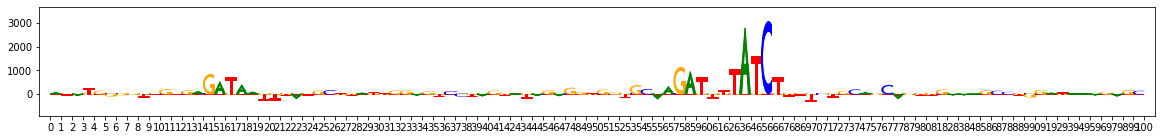

With priors:


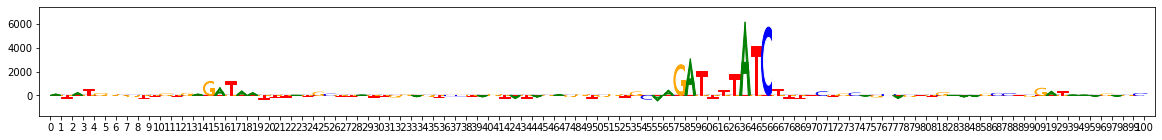

['chr1' 70738633 70739037]
Without priors:


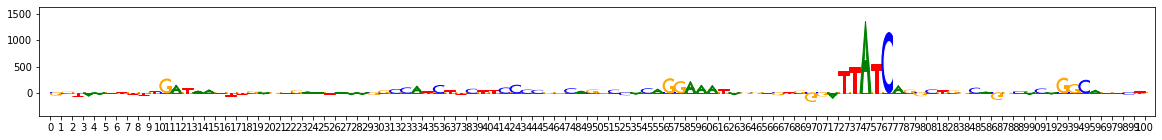

With priors:


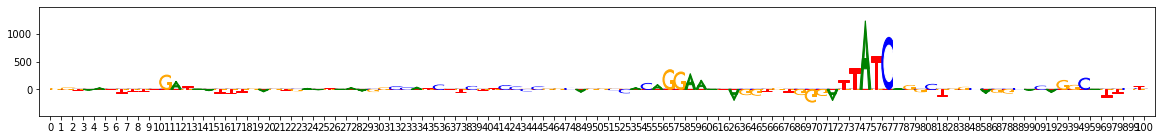

['chr1' 233038597 233039084]
Without priors:


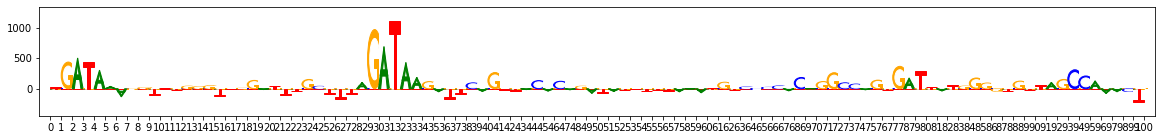

With priors:


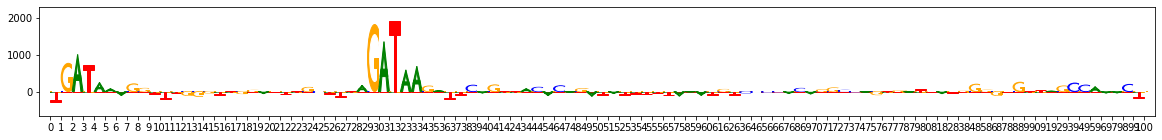

In [49]:
# Plot out a few examples
center_slice = slice(600, 700)
for i in np.random.choice(num_samples, size=3, replace=False):
    print(sample[i])
    print("=========================")
    print("Without priors:")
    viz_sequence.plot_weights(noprior_scores[i, center_slice] * one_hot_seqs[i, center_slice])
    print("With priors:")
    viz_sequence.plot_weights(prior_scores[i, center_slice] * one_hot_seqs[i, center_slice])

### Relate importances to distance from summit(s)

In [20]:
def compute_distance_corr(scores, one_hot_seqs, summit_offsets, window_size=1):
    """
    Windowing by `window_size`, computes the total importance magnitude for the
    actual importance in each window, and correlates that to the distance from
    the summit. If there are multiple summits, then the closest one is used.
    Returns a NumPy array of correlation values, one for each sequence (where
    each correlation is done over the windows of the sequence).
    """
    num_samples = len(scores)
    corr_vals = np.empty(num_samples)
    for i in tqdm.notebook.trange(num_samples):
        score_track = np.sum(np.abs(scores[i] * one_hot_seqs[i]), axis=1)  # Actual importance
        offsets = summit_offsets[i]
        if not offsets:
            print("Warning: found a sequence with no captured summit")
            continue
        num_windows = len(score_track) - window_size + 1
        
        # Compute distances to summits
        distances = np.empty((len(offsets), num_windows))
        window_locs = np.arange(num_windows) + ((len(score_track) - num_windows) / 2)
        for j, offset in enumerate(offsets):
            distances[j] = np.abs(window_locs - offset)
        closest_distances = np.amin(distances, axis=0)
        
        # Compute sum of importance in each window
        importances = np.empty(num_windows)
        for j in range(num_windows):
            importances[j] = np.sum(score_track[j : j + window_size])
            
        corr_vals[i] = scipy.stats.spearmanr(importances, closest_distances)[0]
    return corr_vals

In [52]:
noprior_corrs = compute_distance_corr(noprior_scores, one_hot_seqs, summit_offsets, window_size=1)
prior_corrs = compute_distance_corr(prior_scores, one_hot_seqs, summit_offsets, window_size=1)

Average correlation without priors: -0.318412
Average correlation with priors: -0.366824
Test of difference of means: t = 1.941997, p = 0.026778


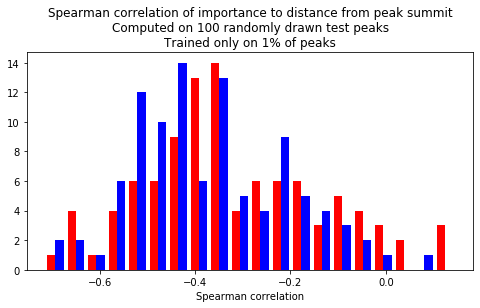

In [53]:
bin_num = 20
plt.figure(figsize=(8, 4))
plt.hist(
    [noprior_corrs, prior_corrs],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"]
)
plt.title(
    "Spearman correlation of importance to distance from peak summit" +
    "\nComputed on 100 randomly drawn test peaks" +
    "\nTrained only on 1% of peaks"
)
plt.xlabel("Spearman correlation")

print("Average correlation without priors: %f" % np.mean(noprior_corrs))
print("Average correlation with priors: %f" % np.mean(prior_corrs))
t, p = scipy.stats.ttest_ind(noprior_corrs, prior_corrs)
print("Test of difference of means: t = %f, p = %f" % (t, p / 2))